<a href="https://colab.research.google.com/github/namkhanh20192935BK/DATN_20232_BK/blob/main/%5BDATN%5D_Fine_tune_SAM_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Cài đặt và import các thư viện cần thiết

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ld99njb9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ld99njb9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=f167cea7f02820a9683a3ef71b97793ac68311b0152f00004c7136e9f7d446fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-0uqvm_ai/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import cv2
from datasets import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random

# Chia dataset để training model

## Chia dataset cho tập train

In [5]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/OTU_2D/train/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", train_images_np.shape)


Kích thước của mảng hình ảnh: (1177, 256, 256, 3)


In [6]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/OTU_2D/train/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
train_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", train_labels_np.shape)

Kích thước của mảng mặt nạ: (1177, 256, 256)


In [7]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in train_images_np],
    "label": [Image.fromarray(mask) for mask in train_labels_np],
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(dataset_dict)

In [8]:
train_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1177
})

## Chia dataset cho tập validation

In [9]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/OTU_2D/validation/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", val_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [10]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/OTU_2D/validation/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
val_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", val_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [11]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in val_images_np],
    "label": [Image.fromarray(mask) for mask in val_labels_np],
}

# Create the dataset using the datasets.Dataset class
val_dataset = Dataset.from_dict(dataset_dict)

In [12]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

## Chia dataset cho tập test

In [13]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/OTU_2D/test/Image"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith(('.JPG')):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (256, 256))

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_images_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng hình ảnh:", test_images_np.shape)


Kích thước của mảng hình ảnh: (146, 256, 256, 3)


In [14]:
# Đường dẫn tới thư mục chứa các hình ảnh
image_folder = "/content/drive/MyDrive/DATN/OTU_2D/test/Label"

# Lấy danh sách các tệp trong thư mục và sắp xếp theo thứ tự tên tăng dần từ A đến Z
image_files = sorted(os.listdir(image_folder))

# Khởi tạo một danh sách để chứa các hình ảnh dưới dạng mảng NumPy
image_array_list = []

# Lặp qua tất cả các tệp trong thư mục đã được sắp xếp
for filename in image_files:
    # Kiểm tra xem tệp có phải là hình ảnh không
    if filename.endswith('.PNG'):
        # Đường dẫn đầy đủ tới hình ảnh
        img_path = os.path.join(image_folder, filename)

        # Đọc hình ảnh
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))
        img = img / 255.0

        # img = np.int32(img)

        # Kiểm tra xem hình ảnh có được đọc thành công hay không
        if img is not None:
            # Thêm hình ảnh vào danh sách
            image_array_list.append(img)
        else:
            print(f"Không thể đọc hình ảnh {filename}")

# Chuyển đổi danh sách hình ảnh thành mảng NumPy
test_labels_np = np.array(image_array_list)

# In ra kích thước của mảng hình ảnh
print("Kích thước của mảng mặt nạ:", test_labels_np.shape)

Kích thước của mảng mặt nạ: (146, 256, 256)


In [15]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in test_images_np],
    "label": [Image.fromarray(mask) for mask in test_labels_np],
}

# Create the dataset using the datasets.Dataset class
test_dataset = Dataset.from_dict(dataset_dict)

In [16]:
test_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

#Kiểm tra ảnh và mặt nạ

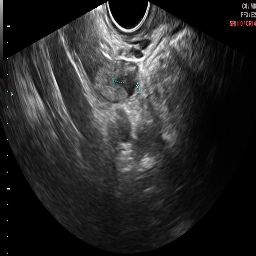

In [17]:
img_num = random.randint(0, train_images_np.shape[0]-1)
example = train_dataset[img_num]
image = example["image"]
image

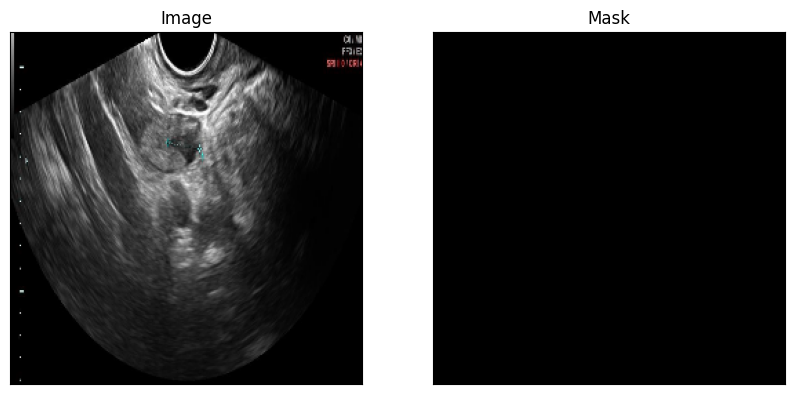

In [18]:
example_image = train_dataset[img_num]["image"]
example_mask = train_dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

(-0.5, 255.5, 255.5, -0.5)

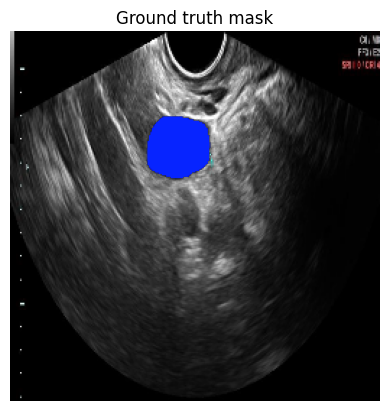

In [19]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.2])], axis=0)
    else:
        color = np.array([30/255, 144/255, 2550/255, 10])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

# Vẽ bounding boxes cho mặt nạ

In [20]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

# Training Model

## Hàm tạo 1 dataset input images and mask

In [21]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt | vẽ box cho mặt nạ
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model | Chuẩn bị mặt nạ và hộp giới hạn
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default | Loại bỏ chiều Batch được thêm vào mặc định
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation | Thêm ground truth để đánh giá việc Segment sau này, đánh giá hiệu suất mô hình
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

## Load model SAM

### Xử lý dữ liệu để tương thích với đầu vào Model

In [22]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [23]:
# Create an instance of the SAMDataseta
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)

In [24]:
example = train_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [25]:
example = val_dataset[0]
for k,v in example.items():
  print(f'{k}: {v.shape}')

pixel_values: torch.Size([3, 1024, 1024])
original_sizes: torch.Size([2])
reshaped_input_sizes: torch.Size([2])
input_boxes: torch.Size([1, 4])
ground_truth_mask: (256, 256)


In [26]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True, drop_last=False)

In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [28]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [29]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

### Load model Pretrained của Segment Anything

In [30]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

### Khởi tạo model với hàm tối ưu là Adam, hàm loss là DiceCELoss

In [31]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

### Train Model

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os

# Tạo thư mục checkpoint nếu chưa tồn tại
checkpoint_dir = '/content/drive/MyDrive/DATN/checkpoint_SAM'
os.makedirs(checkpoint_dir, exist_ok=True)

# Biến để theo dõi loss tốt nhất và trọng số của nó
best_loss = float('inf')
best_weights = None

# Training loop
num_epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    # Lưu trọng số của mô hình sau mỗi epoch vào thư mục checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))

    # Tính loss trung bình của epoch hiện tại
    epoch_loss_mean = mean(epoch_losses)

    # In thông tin về epoch và loss
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {epoch_loss_mean}')

    # Kiểm tra xem loss của epoch hiện tại có là tốt nhất không
    if epoch_loss_mean < best_loss:
        # Nếu là loss tốt nhất, cập nhật biến best_loss và lưu trọng số tốt nhất
        best_loss = epoch_loss_mean
        best_weights = model.state_dict()
        torch.save(best_weights, os.path.join(checkpoint_dir, '/content/drive/MyDrive/DATN/best_checkpoint_SAM/best_model_weights.pt'))
        print("Best model weights saved.")


100%|██████████| 3/3 [03:36<00:00, 72.13s/it]


EPOCH: 0
Mean loss: 0.9160422086715698
Best model weights saved.


100%|██████████| 3/3 [03:24<00:00, 68.21s/it]


EPOCH: 1
Mean loss: 0.7734914223353068
Best model weights saved.


100%|██████████| 3/3 [03:35<00:00, 71.96s/it]


EPOCH: 2
Mean loss: 0.751518964767456
Best model weights saved.


100%|██████████| 3/3 [03:38<00:00, 72.99s/it]


EPOCH: 3
Mean loss: 0.6807768146197001
Best model weights saved.


100%|██████████| 3/3 [03:22<00:00, 67.66s/it]


EPOCH: 4
Mean loss: 0.6469164888064066
Best model weights saved.


### Early Stopping

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DATN/weight/checkpoint_10.pth"))

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os

# Tạo thư mục checkpoint nếu chưa tồn tại
checkpoint_dir = '/content/drive/MyDrive/DATN/checkpoint_SAM'
os.makedirs(checkpoint_dir, exist_ok=True)

# Biến để theo dõi loss tốt nhất và trọng số của nó
best_loss = float('inf')
best_weights = None

# Early stopping parameters
patience = 3  # Số lượng epochs mà mô hình không cải thiện trước khi dừng sớm
counter = 0

# Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

        # Tính accuracy
        predicted_labels = torch.argmax(predicted_masks, dim=1)
        correct_predictions += torch.sum(predicted_labels == ground_truth_masks).item()
        total_predictions += ground_truth_masks.numel()

    # Lưu trọng số của mô hình sau mỗi epoch vào thư mục checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))

    # Tính loss trung bình và accuracy của epoch hiện tại
    epoch_loss_mean = mean(epoch_losses)
    accuracy = correct_predictions / total_predictions

    # In thông tin về epoch, loss và accuracy
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {epoch_loss_mean}')
    print(f'Accuracy: {accuracy}')

    # Kiểm tra xem loss của epoch hiện tại có là tốt nhất không
    if epoch_loss_mean < best_loss:
        # Nếu là loss tốt nhất, cập nhật biến best_loss và lưu trọng số tốt nhất
        best_loss = epoch_loss_mean
        best_weights = model.state_dict()
        torch.save(best_weights, os.path.join(checkpoint_dir, 'best_model_weights.pt'))
        print("Best model weights saved.")

    # Kiểm tra early stopping
    if epoch > 0:  # Bắt đầu kiểm tra early stopping sau epoch đầu tiên
        if epoch_loss_mean >= prev_epoch_loss:
            counter += 1
            if counter >= patience:
                print(f"Early stopping! No improvement in {patience} epochs.")
                break
        else:
            counter = 0  # Reset counter
    prev_epoch_loss = epoch_loss_mean  # Lưu loss của epoch hiện tại để so sánh với epoch tiếp theo


100%|██████████| 589/589 [09:50<00:00,  1.00s/it]


EPOCH: 0
Mean loss: 0.43683209108324733
Accuracy: 0.8530938108795866
Best model weights saved.


100%|██████████| 589/589 [09:52<00:00,  1.01s/it]


EPOCH: 1
Mean loss: 0.3385175408223084
Accuracy: 0.8530938108795866
Best model weights saved.


100%|██████████| 589/589 [09:53<00:00,  1.01s/it]


EPOCH: 2
Mean loss: 0.3134594107954328
Accuracy: 0.8530938108795866
Best model weights saved.


100%|██████████| 589/589 [09:53<00:00,  1.01s/it]


EPOCH: 3
Mean loss: 0.3042094527486022
Accuracy: 0.8530938108795866
Best model weights saved.


100%|██████████| 589/589 [09:52<00:00,  1.01s/it]


EPOCH: 4
Mean loss: 0.28934675060427656
Accuracy: 0.8530938108795866
Best model weights saved.


 42%|████▏     | 248/589 [04:08<05:46,  1.01s/it]

### Load hàm loss đánh giá model

In [35]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Define functions for calculating evaluation metrics
def dice_coefficient(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    return (2. * intersection + 1) / (union + 1)  # Smoothing to avoid division by zero

def iou(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target) - intersection
    return (intersection + 1) / (union + 1)  # Smoothing to avoid division by zero

def recall(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_negative = torch.sum(target) - true_positive
    return true_positive / (true_positive + false_negative + 1)  # Smoothing to avoid division by zero

def precision(predicted, target):
    true_positive = torch.sum(predicted * target)
    false_positive = torch.sum(predicted) - true_positive
    return true_positive / (true_positive + false_positive + 1)  # Smoothing to avoid division by zero

### Đánh giá trọng số mô hình với tập Validation Dataset (IOU, Precision, Recall, Dice)

In [37]:
# Tải trọng số từ checkpoint
checkpoint_path = "/content/drive/MyDrive/DATN/checkpoint_SAM/model_epoch_4.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Load trọng số vào mô hình
model.load_state_dict(checkpoint)


# Đặt mô hình vào chế độ đánh giá
model.eval()

# Tiếp tục quá trình kiểm tra mô hình như đã thực hiện trước đó
val_dice_scores = []
val_iou_scores = []
val_recall_scores = []
val_precision_scores = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute evaluation metrics
        predicted_masks = torch.sigmoid(outputs['pred_masks'].squeeze(1)) > 0.5
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        val_dice_scores.append(dice_coefficient(predicted_masks, ground_truth_masks))
        val_iou_scores.append(iou(predicted_masks, ground_truth_masks))
        val_recall_scores.append(recall(predicted_masks, ground_truth_masks))
        val_precision_scores.append(precision(predicted_masks, ground_truth_masks))

# Print evaluation metrics
print("\n")
print(f'Validation Dice: {torch.tensor(val_dice_scores).mean()}')
print(f'Validation IOU: {torch.tensor(val_iou_scores).mean()}')
print(f'Validation Recall: {torch.tensor(val_recall_scores).mean()}')
print(f'Validation Precision: {torch.tensor(val_precision_scores).mean()}')


100%|██████████| 73/73 [1:31:53<00:00, 75.52s/it]



Validation Dice: 0.0010893904836848378
Validation IOU: 0.0010893904836848378
Validation Recall: 0.0
Validation Precision: 0.0


### Train tiếp model từ trọng số

In [46]:
# Đường dẫn tới checkpoint
checkpoint_path = "/content/drive/MyDrive/DATN/checkpoint_SAM/model_epoch_4.pt"

# Tải checkpoint lên CPU
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# Sử dụng checkpoint để cập nhật trạng thái của mô hình
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
import os

# Tạo thư mục checkpoint nếu chưa tồn tại
checkpoint_dir = '/content/drive/MyDrive/DATN/checkpoint_SAM'
os.makedirs(checkpoint_dir, exist_ok=True)

# Biến để theo dõi loss tốt nhất và trọng số của nó
best_loss = float('inf')
best_weights = None

# Early stopping parameters
patience = 3  # Số lượng epochs mà mô hình không cải thiện trước khi dừng sớm
counter = 0

# Training loop
num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

        # Tính accuracy
        predicted_labels = torch.argmax(predicted_masks, dim=1)
        correct_predictions += torch.sum(predicted_labels == ground_truth_masks).item()
        total_predictions += ground_truth_masks.numel()

    # Lưu trọng số của mô hình sau mỗi epoch vào thư mục checkpoint
    torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt'))

    # Tính loss trung bình và accuracy của epoch hiện tại
    epoch_loss_mean = mean(epoch_losses)
    accuracy = correct_predictions / total_predictions

    # In thông tin về epoch, loss và accuracy
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {epoch_loss_mean}')
    print(f'Accuracy: {accuracy}')

    # Kiểm tra xem loss của epoch hiện tại có là tốt nhất không
    if epoch_loss_mean < best_loss:
        # Nếu là loss tốt nhất, cập nhật biến best_loss và lưu trọng số tốt nhất
        best_loss = epoch_loss_mean
        best_weights = model.state_dict()
        torch.save(best_weights, os.path.join(checkpoint_dir, 'best_model_weights_5.pt'))
        print("Best model weights saved.")

    # Kiểm tra early stopping
    if epoch > 0:  # Bắt đầu kiểm tra early stopping sau epoch đầu tiên
        if epoch_loss_mean >= prev_epoch_loss:
            counter += 1
            if counter >= patience:
                print(f"Early stopping! No improvement in {patience} epochs.")
                break
        else:
            counter = 0  # Reset counter
    prev_epoch_loss = epoch_loss_mean  # Lưu loss của epoch hiện tại để so sánh với epoch tiếp theo


  0%|          | 1/589 [02:35<25:22:13, 155.33s/it]


KeyboardInterrupt: 

#Kiểm thử mô hình

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/DATN/best_checkpoint_SAM"))

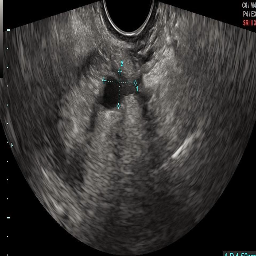

In [38]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 0

# load image
image = test_dataset[0]["image"]
image

In [39]:
import torch
# Sử dụng GPU nếu có sẵn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(test_dataset[0]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [42]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [43]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(-0.5, 255.5, 255.5, -0.5)

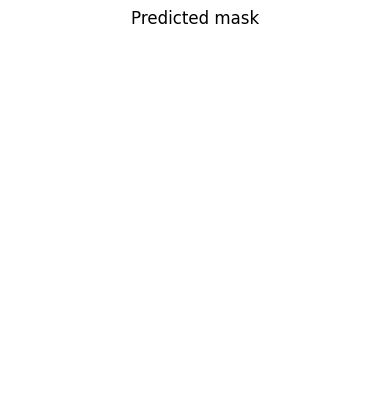

In [51]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 25500/255, 100])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

# axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [ ]:
import torch.nn.functional as F
from typing import Tuple
from torch.nn import MSELoss

loss_fn = MSELoss()

def postprocess_masks(masks: torch.Tensor, input_size: Tuple[int, ...], original_size: Tuple[int, ...], image_size=1024) -> torch.Tensor:
    """
    Remove padding and upscale masks to the original image size.

    Args:
      masks (torch.Tensor):
        Batched masks from the mask_decoder, in BxCxHxW format.
      input_size (tuple(int, int)):
        The size of the image input to the model, in (H, W) format. Used to remove padding.
      original_size (tuple(int, int)):
        The original size of the image before resizing for input to the model, in (H, W) format.

    Returns:
      (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
        is given by original_size.
    """
    masks = F.interpolate(
        masks,
        (image_size, image_size),
        mode="bilinear",
        align_corners=False,
    )
    masks = masks[..., : input_size[0], : input_size[1]]
    masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
    return masks